In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import collections
from collections import Counter
import pandas as pd
import codecs
import re
import os.path

# Données classification de sentiments (films)

In [4]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [5]:
path = "./datasets/movies/movies1000/"

alltxts,alllabs = load_movies(path)

In [6]:
print(len(alltxts),len(alllabs))

2000 2000


# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [33]:
import re
import unicodedata
import string
import nltk
import spacy

def preprocess(text, lemma = False):
    """
    Transforms text to remove unwanted bits.
    """
    
    # Characters suppression 
    
    # Non normalized char suppression 
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    
    # Lowercase transformation
    text = text.lower()

    # Punctuation suppression
    translation_table = str.maketrans("", "", string.punctuation + '\n\r\t')
    text = text.translate(translation_table)
    
    # Digits suppression
    text = re.sub(r'\d', '', text)
    # Use the sub function to replace double spaces with single spaces
    text = re.sub(r'\s+', ' ', text)
 
    if lemma:
        nlp = spacy.load("en_core_web_sm")
        lemmatised_text = nlp(text)
        text = [str(word.lemma_) for word in lemmatised_text]
        text = ' '.join(text)
    
    return text


In [50]:
# Preprocess the data
alltxt_test = preprocess(alltxts[0], True)
print("Le texte avant modification : ", alltxts[0])
print("Le text aprés modification : ", alltxt_test)

Le texte avant modification :  i want to be involved in show business one day and i refuse to do any sequels to any movie i may make because i believe they only get worse this movie proves it for me i was a little worried about the last batman film as i thought joel schumaccer taking over from tim burton would screw it up i also assumed val kilmer would screw up as bruce wayne they didnt kilmer did a good job and the cast was left to carry the movie which they did even jim carrey as the riddler and i cant stand jim carrey because schumaccer messed up the direction with his glitzy gotham and his awkward camera angles this film is different the cast is still impressive but here not only does schumaccer mess up with the direction hes one of those directors whos good with actors terrible with camera angles but writer akiva goldsmith doesnt really give an impressive cast anything to do the cast is impressive clooney is a surprisingly good waynebatman odonnell is a crafty robin as usual they

# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendre ? Quels sont les avantages et les inconvénients des ces variantes?**

In [42]:
movies_df = pd.DataFrame()
movies_df['text'] = alltxts
movies_df['label'] = alllabs

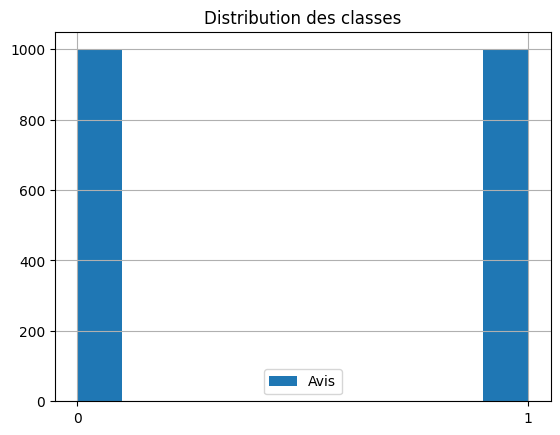

In [46]:
#Distribution des classes

movies_df['label'].hist()
plt.title('Distribution des classes')
plt.xticks([0, 1])
plt.legend(labels=['Avis'])
plt.show()

Les classes sont distribués de maniére equivalente 

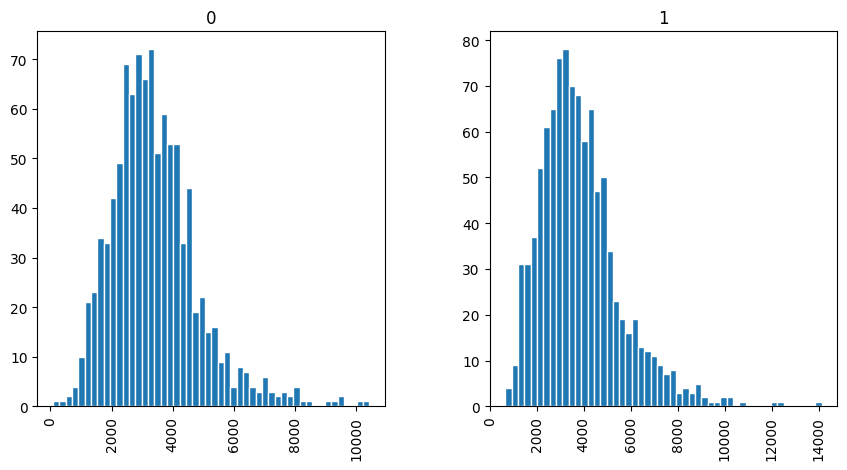

In [49]:
# Longueure des documents par classes

movies_df.text.map(len).hist(bins=50, edgecolor='white', by=movies_df['label'], figsize=(10, 5))
plt.show()

## Extraction du vocabulaire et differente analyse : 

In [75]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(movies_df.text)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))
print("mots du vocabulaire : ", vectorizer.vocabulary_.keys())

Taille initiale du vocabulaire : 46762
mots du vocabulaire :  dict_keys(['want', 'to', 'be', 'involved', 'in', 'show', 'business', 'one', 'day', 'and', 'refuse', 'do', 'any', 'sequels', 'movie', 'may', 'make', 'because', 'believe', 'they', 'only', 'get', 'worse', 'this', 'proves', 'it', 'for', 'me', 'was', 'little', 'worried', 'about', 'the', 'last', 'batman', 'film', 'as', 'thought', 'joel', 'schumaccer', 'taking', 'over', 'from', 'tim', 'burton', 'would', 'screw', 'up', 'also', 'assumed', 'val', 'kilmer', 'bruce', 'wayne', 'didnt', 'did', 'good', 'job', 'cast', 'left', 'carry', 'which', 'even', 'jim', 'carrey', 'riddler', 'cant', 'stand', 'messed', 'direction', 'with', 'his', 'glitzy', 'gotham', 'awkward', 'camera', 'angles', 'is', 'different', 'still', 'impressive', 'but', 'here', 'not', 'does', 'mess', 'hes', 'of', 'those', 'directors', 'whos', 'actors', 'terrible', 'writer', 'akiva', 'goldsmith', 'doesnt', 'really', 'give', 'an', 'anything', 'clooney', 'surprisingly', 'waynebatman

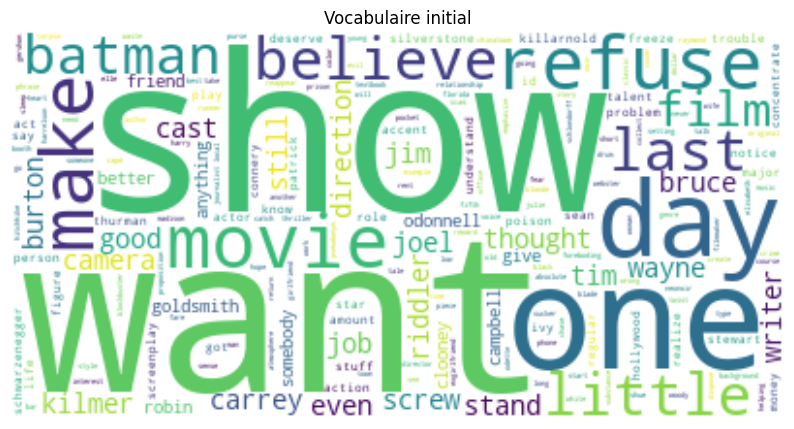

In [74]:
wc = WordCloud(background_color='white').generate(' '.join(vectorizer.vocabulary_.keys()))
plt.figure(figsize=(10, 8))
plt.title('Vocabulaire initial')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Mots les plus fréquent avec et sans les stopwords

In [165]:
preprocessed_text = preprocess(" ".join(movies_df.text))

In [128]:
#Remove stopwords :
from nltk.corpus import stopwords
 
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = text.split()
    no_stop_words = [word for word in text if word not in stop_words]
    text = ' '.join(no_stop_words)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NeilB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


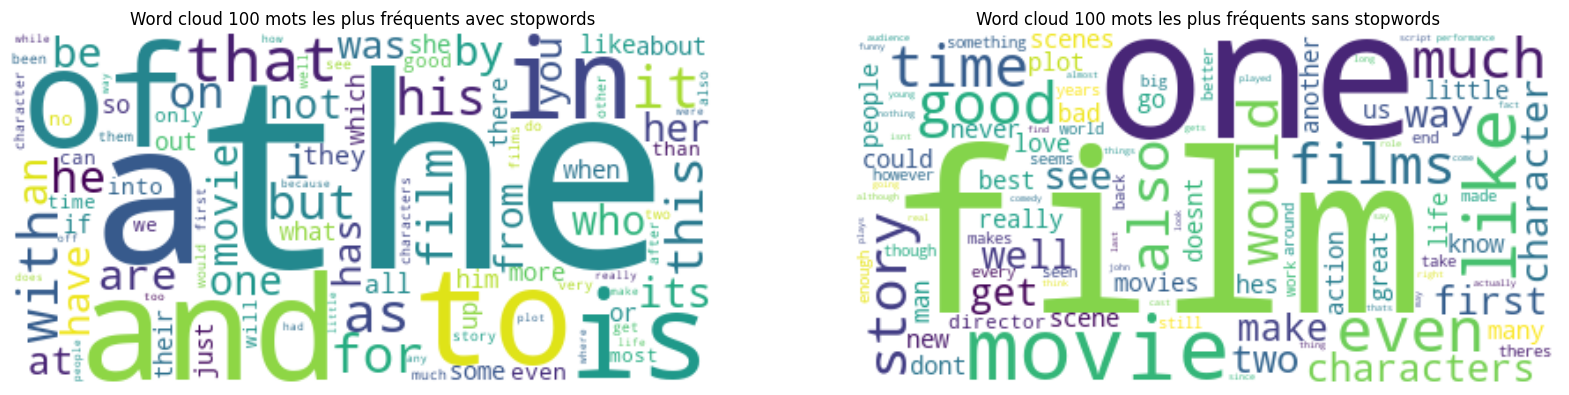

In [134]:
ptext_nosw = remove_stopwords(preprocessed_text)

words = ptext_nosw.split()
word_counter = Counter(words)

top_100_no_stop_words = dict(word_counter.most_common(100))
words = " ".join(movies_df.text).split()
word_counter = Counter(words)
top_100_words = dict(word_counter.most_common(100))
# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Créer le premier word cloud et l'afficher sur le premier sous-graphique
wc1 = WordCloud(background_color='white').generate_from_frequencies(top_100_words)
ax1.imshow(wc1, interpolation='bilinear')
ax1.set_title('Word cloud 100 mots les plus fréquents avec stopwords')
ax1.axis("off")

# Créer le deuxième word cloud et l'afficher sur le deuxième sous-graphique
wc2 = WordCloud(background_color='white').generate_from_frequencies(top_100_no_stop_words)
ax2.imshow(wc2, interpolation='bilinear')
ax2.set_title('Word cloud 100 mots les plus fréquents sans stopwords')
ax2.axis("off")

# Afficher la figure
plt.show()

Top 100 des mots les plus fréquent pour chacune des classes :  

In [141]:
neg_corpus = movies_df[movies_df.label == 0].text
pos_corpus = movies_df[movies_df.label == 1].text

neg_corpus_preprocessed_text = preprocess(" ".join(neg_corpus))
pos_corpus_preprocessed_text = preprocess(" ".join(pos_corpus))


i want to be involved in show business one day and i refuse to do any sequels to any movie i may make because i believe they only get worse this movie proves it for me i was a little worried about the last batman film as i thought joel schumaccer taking over from tim burton would screw it up i also assumed val kilmer would screw up as bruce wayne they didnt kilmer did a good job and the cast was left to carry the movie which they did even jim carrey as the riddler and i cant stand jim carrey because schumaccer messed up the direction with his glitzy gotham and his awkward camera angles this film is different the cast is still impressive but here not only does schumaccer mess up with the direction hes one of those directors whos good with actors terrible with camera angles but writer akiva goldsmith doesnt really give an impressive cast anything to do the cast is impressive clooney is a surprisingly good waynebatman odonnell is a crafty robin as usual they couldve casted somebody better

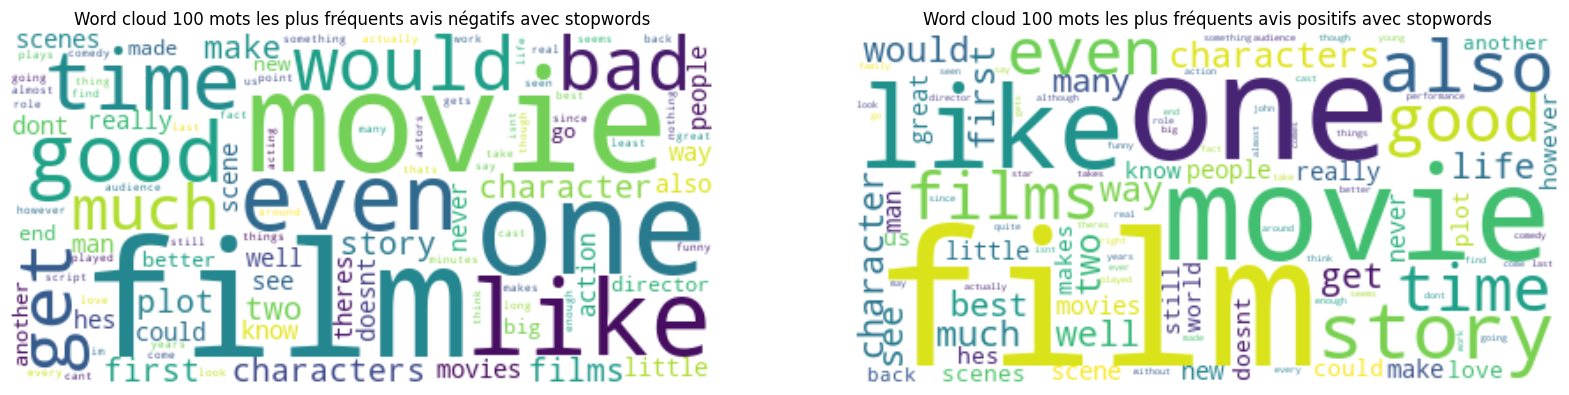

In [143]:
ptext_neg_nosw = remove_stopwords(neg_corpus_preprocessed_text)
ptext_pos_nosw = remove_stopwords(pos_corpus_preprocessed_text)

words_neg = ptext_neg_nosw.split()
words_pos = ptext_pos_nosw.split()
word_counter_neg = Counter(words_neg)
word_counter_pos = Counter(words_pos)

top_100_neg_words = dict(word_counter_neg.most_common(100))
top_100_pos_words = dict(word_counter_pos.most_common(100))
# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Créer le premier word cloud et l'afficher sur le premier sous-graphique
wc1 = WordCloud(background_color='white').generate_from_frequencies(top_100_neg_words)
ax1.imshow(wc1, interpolation='bilinear')
ax1.set_title('Word cloud 100 mots les plus fréquents avis négatifs avec stopwords')
ax1.axis("off")

# Créer le deuxième word cloud et l'afficher sur le deuxième sous-graphique
wc2 = WordCloud(background_color='white').generate_from_frequencies(top_100_pos_words)
ax2.imshow(wc2, interpolation='bilinear')
ax2.set_title('Word cloud 100 mots les plus fréquents avis positifs avec stopwords')
ax2.axis("off")

# Afficher la figure
plt.show()

Regardant les mots les plus fréquent en commun, on peut remarquer que la grande majorité n'est pas un facteur descriminant

166


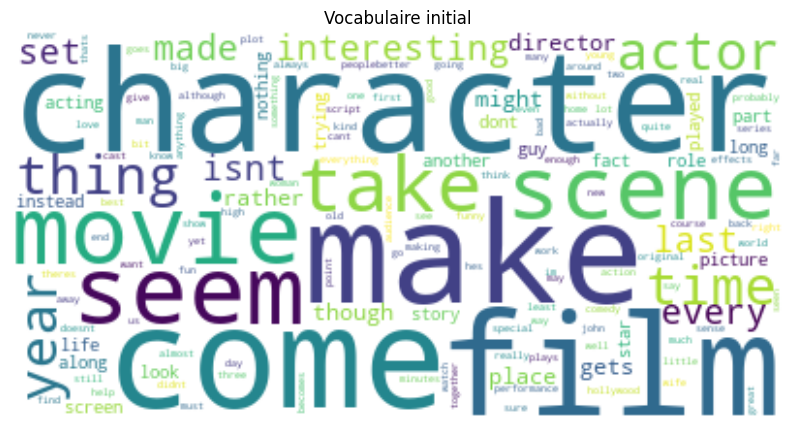

In [160]:
ptext_neg_nosw = remove_stopwords(neg_corpus_preprocessed_text)
ptext_pos_nosw = remove_stopwords(pos_corpus_preprocessed_text)

words_neg = ptext_neg_nosw.split()
words_pos = ptext_pos_nosw.split()
word_counter_neg = Counter(words_neg)
word_counter_pos = Counter(words_pos)

top_100_neg_words = dict(word_counter_neg.most_common(200))
top_100_pos_words = dict(word_counter_pos.most_common(200))

common_words = set(top_100_neg_words.keys()).intersection(set(top_100_pos_words.keys()))

# Afficher les mots en commun
print(len(common_words))

wc = WordCloud(background_color='white').generate(' '.join(common_words))
plt.figure(figsize=(10, 8))
plt.title('Vocabulaire initial')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

On peut noter qu'il y'a beacoup de mot qui se répete, et certains mot qui sont descriminant meme par exemple on trouve les  mots " bad, less " pour les avis négatif mais pas dans les avis positifs, il serait donc interessant de voir les mots  fréquent en commun, on pourrait essayer de les inclure dans les stopwords comme  les mots : film ou movie. On pourrait donc  aussi envisager  des trigrams ou bigram qui ferait les disctinction entre " bad film "  et " good film " 
( meme si le tfidf  le fera en quelque sorte tout seul )

### Mots les plus fréquent au sens du odds ratio : 

(-0.5, 399.5, 199.5, -0.5)

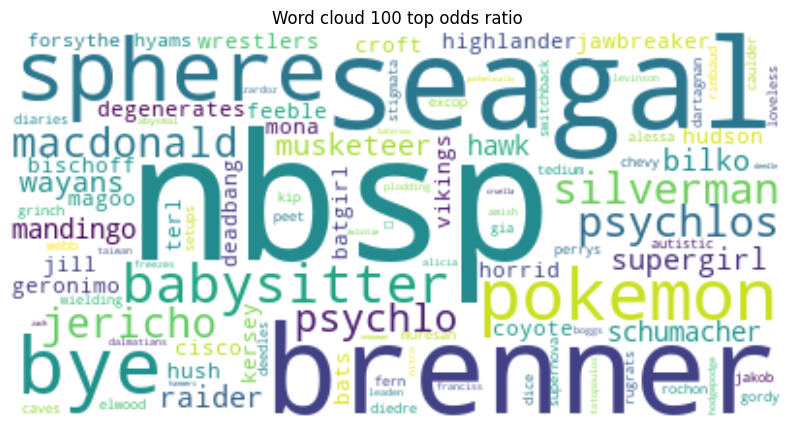

In [146]:
ptext_neg_nosw = remove_stopwords(neg_corpus_preprocessed_text)
ptext_pos_nosw = remove_stopwords(pos_corpus_preprocessed_text)

words_neg = ptext_neg_nosw.split()
words_pos = ptext_pos_nosw.split()

word_counter_neg = Counter(words_neg)
word_counter_pos = Counter(words_pos)

odds_ratios = {}

for word, freq_class1 in word_counter_neg.items():
    freq_class2 = word_counter_pos[word]
    total_words_class1 = sum(word_counter_neg.values())
    total_words_class2 = sum(word_counter_pos.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(word_counter_neg))) / ((freq_class2 + 1) / (total_words_class2 + len(word_counter_pos)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud(background_color='white').generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

### Loi de zipf's avec et sans stopwords

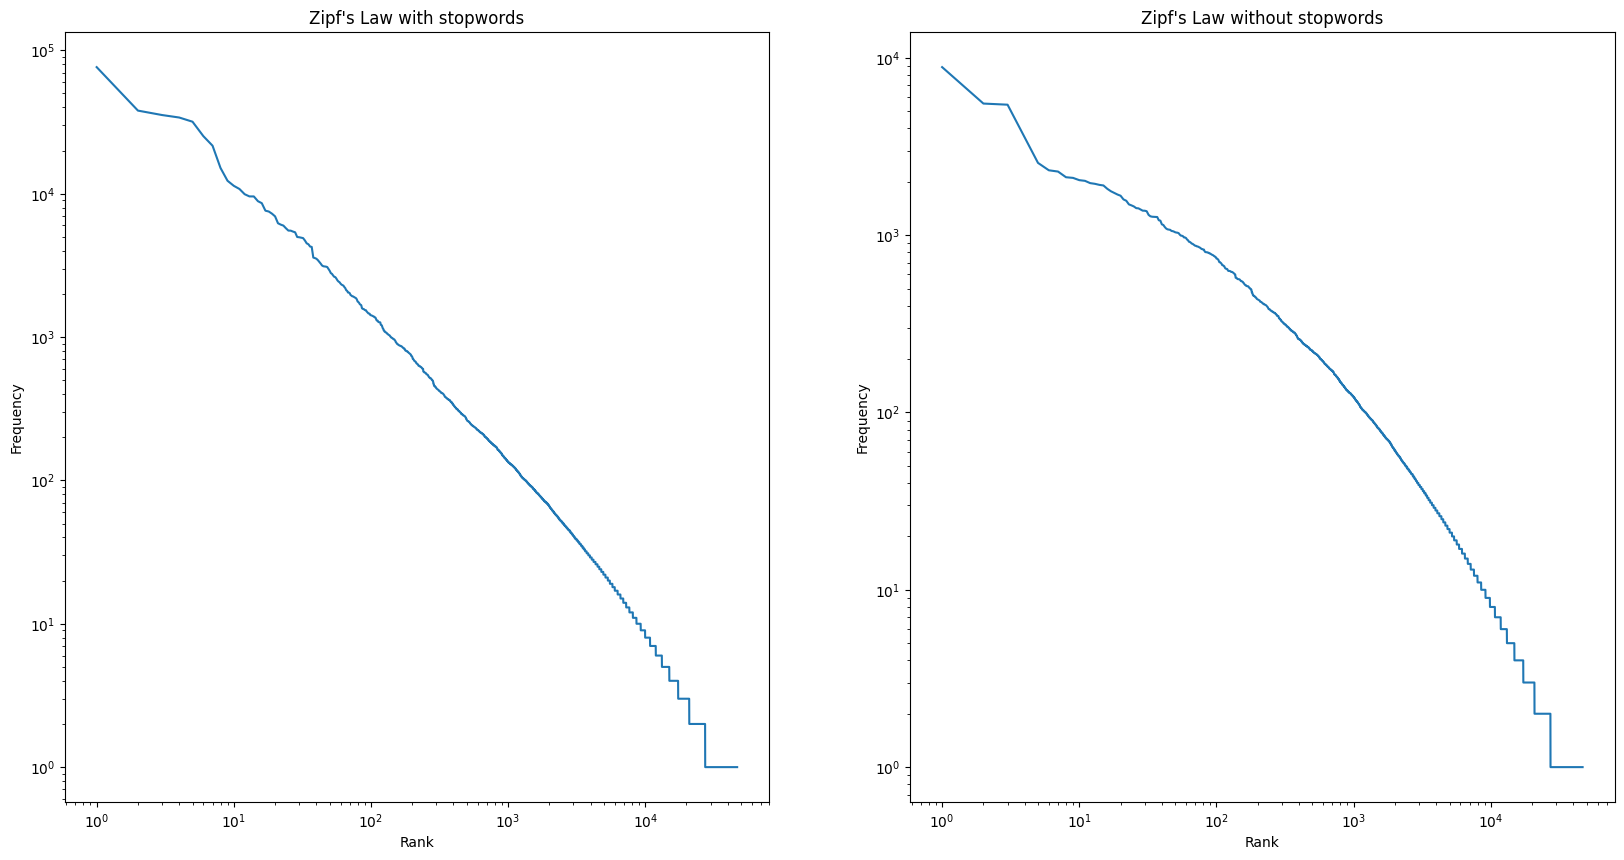

In [154]:
corpus_clean_avec_stopwords = preprocessed_text
corpus_clean = remove_stopwords(preprocessed_text)
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
word_freqs = [word_counts[w] for w in sorted_words]
ranks = range(1, len(sorted_words) + 1)


def plot_zipfs_law(corpus, title, ax):
    # Obtenir les mots et leurs fréquences
    word_counts = Counter(corpus.split())
    
    # Trier les mots du plus fréquent au moins fréquent
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    
    # Obtenir les fréquences des mots triés
    word_freqs = [word_counts[w] for w in sorted_words]
    
    # Obtenir les rangs des mots triés
    ranks = range(1, len(sorted_words) + 1)
    
    # Afficher le graphique sur le sous-graphe spécifié
    ax.plot(ranks, word_freqs)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Frequency')
# Créer une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Afficher le graphique avec stopwords sur le premier sous-graphique
plot_zipfs_law(corpus_clean_avec_stopwords, 'Zipf\'s Law with stopwords', ax1)

# Afficher le graphique sans stopwords sur le deuxième sous-graphique
plot_zipfs_law(corpus_clean, 'Zipf\'s Law without stopwords', ax2)

# Afficher la figure
plt.show()

### Bi-Gram et Tri-gram

In [166]:
movies_df.text

0       i want to be involved in show business one day...
1       in french the phrase film noir literally means...
2       a big house a big director jan de bont of spee...
3       if only austin powers the spy who shagged me h...
4       you know the plot a dimwit with a shady past i...
                              ...                        
1995    strange days chronicles the last two days of i...
1996    i know what i would do with million if i found...
1997    sometimes you just have to tip your hat to a f...
1998     the fugitive is probably one of the greatest ...
1999    plot a bigtime mommas boy cant seem to leave h...
Name: text, Length: 2000, dtype: object

In [168]:
vectorizer = CountVectorizer(ngram_range=(2,2))

preprocessed_alltxts = [preprocess(alltxt) for alltxt in movies_df.text]

X = vectorizer.fit_transform(preprocessed_alltxts)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

,bigram,frequency
0,of the,8750
1,in the,5811
2,the film,4031
3,to the,2782
4,to be,2712
...,...,...
95,like the,393
96,and it,393
97,be the,384
98,and then,381


On remarque beacoup de bi gram en forme de stopwords, et si on traiter les stopwords avant de faire les bi gram ? 

In [169]:
vectorizer = CountVectorizer(ngram_range=(2,2))

preprocessed_alltxts = [preprocess(alltxt) for alltxt in movies_df.text]
ptxts_nosw = [remove_stopwords(txt) for txt in preprocessed_alltxts]
X = vectorizer.fit_transform(ptxts_nosw)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

,bigram,frequency
0,special effects,375
1,new york,244
2,even though,222
3,high school,172
4,star wars,167
...,...,...
95,every time,64
96,go see,63
97,movie like,63
98,eddie murphy,63


On peut remarquer qu'il  n'ya  plus de stopwords, en plus de ca certains mots ont plus de sens par exemple "high school", mais est ce qu'on perd certaines informartions en enlevant des stopwords ? On essayera de creer notre propre liste de  stopwords en bi gram et la meme chose en tri-gram

In [172]:
vectorizer = CountVectorizer(ngram_range=(3,3))

preprocessed_alltxts = [preprocess(alltxt) for alltxt in movies_df.text]

ptxts_nosw = [remove_stopwords(txt) for txt in preprocessed_alltxts]

X = vectorizer.fit_transform(preprocessed_alltxts)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

,bigram,frequency
0,one of the,1026
1,of the film,806
2,in the film,557
3,the film is,542
4,some of the,363
...,...,...
95,that this is,83
96,as much as,83
97,the first time,81
98,for the most,81


In [174]:
vectorizer = CountVectorizer(ngram_range=(3,3))

preprocessed_alltxts = [preprocess(alltxt) for alltxt in movies_df.text]
ptxts_nosw = [remove_stopwords(txt) for txt in preprocessed_alltxts]

X = vectorizer.fit_transform(ptxts_nosw)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

,bigram,frequency
0,know last summer,60
1,new york city,52
2,saving private ryan,49
3,tommy lee jones,44
4,ive ever seen,43
...,...,...
95,best films year,12
96,full metal jacket,12
97,minutes screen time,12
98,star trek next,12


# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.


## 4) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?